# ライブラリ

In [1]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [2]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)

#ライブラリ
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set() # グラフ描画用
from sklearn.metrics import classification_report

import pandas as pd

from pycm import ConfusionMatrix

import csv

import time
from datetime import datetime
import pytz

0.10.2.post1
2.2.2


# データセットの作成

In [3]:
sr = 44100 #サンプリング周波数

## ラベルを含んだデータセット化

In [4]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [5]:
#object層
objLabel = [
    "y-shirt", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "alumi-rack", 
    
    "wood-desk", 
    "wood-shelf", 
    "floor", 
    
    "pla-Case", 
    "pla-Container", 
    "pla-Shelf"
]
objNum= list(range(21))

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [6]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [7]:
# # num_feature次元のMFCCのデータフレームを作成

# # ファイル名の生成と追加
# filenames = []
# for target_num in range(21):
#     for trial in range(50):
#         filenames.append(f'trim-data_{target_num}_{trial}.wav')

# Dataset = pd.DataFrame()

# Dataset['filename'] = filenames
# Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
# Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
# Dataset['shNum'] = np.array([0]*450 + [1]*600)

# # データセットに'objLabel'の列を追加
# Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # # データセットに'matLabel'の列を追加
# Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # # データセットに'SHLabel'の列を追加
# Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# # データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset.csv'
# Dataset.to_csv(csv_path, index=False)

# # Display the DataFrame
# pd.set_option('display.max_rows', 100)


Dataset = pd.read_csv('data/meta_data/dataset.csv')
Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [8]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])
        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [9]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,...,3.645248,3.399917,3.804335,3.734329,0,0,0,y-shirt,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,...,3.640349,3.322606,3.285746,3.343535,0,0,0,y-shirt,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,...,3.156580,3.407280,3.517655,3.547526,0,0,0,y-shirt,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,...,3.725960,3.272637,3.092343,3.604951,0,0,0,y-shirt,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,...,3.328177,3.571923,3.805326,4.301650,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,...,3.297809,3.660277,3.493659,4.016997,20,6,1,pla-Shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,...,3.441372,3.365149,3.482850,4.577083,20,6,1,pla-Shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,...,3.539720,3.766647,4.083665,4.772348,20,6,1,pla-Shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,...,3.418645,3.032147,3.479765,4.267387,20,6,1,pla-Shelf,plastic,hard


### メルスペクトログラムのデータセット

In [10]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
Dataset_melspec = np.expand_dims(Dataset_melspec,1)

print(Dataset_melspec.shape)
print(type(Dataset_melspec))

# ラベルのデータセット
Dataset_label = Dataset.iloc[:,1:4]
Dataset_label_np = Dataset_label.to_numpy()

(1050, 1, 128, 130)
<class 'numpy.ndarray'>


### データ分割

In [11]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)



In [12]:
# テンソルに変換
Dataset_melspec_tensor = torch.tensor(Dataset_melspec, dtype=torch.float32)
Dataset_label_tensor = torch.tensor(Dataset_label_np, dtype=torch.int64)

# split (stratify by the first column of labels as an example)
train_feature_all, eval_feature_all, train_labels_all, eval_labels_all = train_test_split(
    Dataset_melspec_tensor, Dataset_label_tensor, 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.7
)

val_feature_all, test_feature_all, val_labels_all, test_labels_all = train_test_split(
    eval_feature_all, eval_labels_all, 
    stratify=eval_labels_all[:, 0], shuffle=True, random_state=0, train_size=0.5
)

print(train_labels_all.shape,val_labels_all.shape,test_labels_all.shape)


torch.Size([735, 3]) torch.Size([157, 3]) torch.Size([158, 3])


In [13]:
# 学習データにない物体の評価用データセットの作成
def Make_other_dataset(num):

    start = num*trials
    end = (num+1)*trials

    #テストデータの抽出
    test_feature = Dataset_melspec_tensor[start:end,:,:,:]
    test_labels = Dataset_label_tensor[start:end,:]

    #テストデータ以外でデータセットを作成
    other_feature = torch.cat((Dataset_melspec_tensor[:start,:,:,:],Dataset_melspec_tensor[end:,:,:,:]),dim=0)
    other_labels = torch.cat((Dataset_label_tensor[:start,:],Dataset_label_tensor[end:,:]),dim=0)

    #trainとvalに分割
    train_feature, val_feature, train_labels, val_labels = train_test_split(
        other_feature, other_labels, 
    stratify=other_labels[:, 0], shuffle=True, random_state=0, train_size=0.8
    )   
    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels

# 使用
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

In [14]:
def Alldataset():
    train_feature=train_feature_all
    train_labels=train_labels_all
    val_feature=val_feature_all
    val_labels=val_labels_all
    test_feature=test_feature_all
    test_labels=test_labels_all

    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels


# 評価

## CNNでの評価

In [15]:
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

### モデルの保存関数

In [16]:
def Time():
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')
    # 現在の日本時間を取得
    now = datetime.now(jst)
    # 時刻を指定された形式の文字列に変換
    time = now.strftime("%Y%m%d%H%M")

    return time

In [17]:
def SaveModel(model,modelname,eval_num):
    time = Time()
    model_path = 'data/models_saved/'+time+"_"+modelname+'_'+str(eval_num)+'.pth'
    torch.save(model, model_path)

# #読み込み用
# model_path = 'data/models_saved/shModel_1_202406281304.pth'
# xModel = torch.load(model_path)

### 評価関数

In [18]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN(data_loader,device,num_label,num_trial):
    with torch.no_grad():
        if num_label == 0:
            model = shModel_trained
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            model = matModel_trained
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            model = objModel_trained
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            pred = torch.argmax(y[0], dim=1)
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()

        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "confusion_matrix_"+model_name
        plt.title(title)
        plt.xlabel('predict')
        plt.ylabel('actual')
        plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
        plt.show()
        plt.close()
            
    return preds, actuals,report_out

/opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

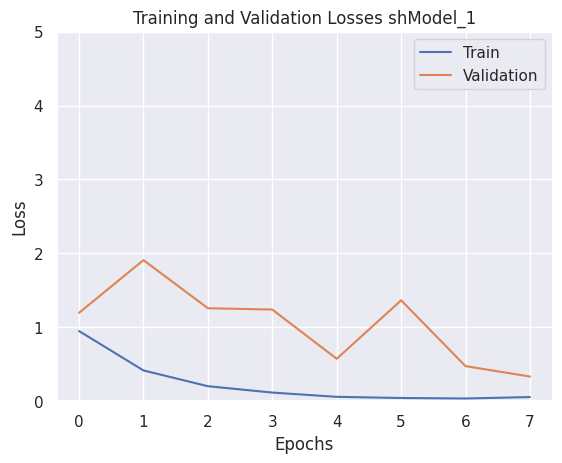

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.p

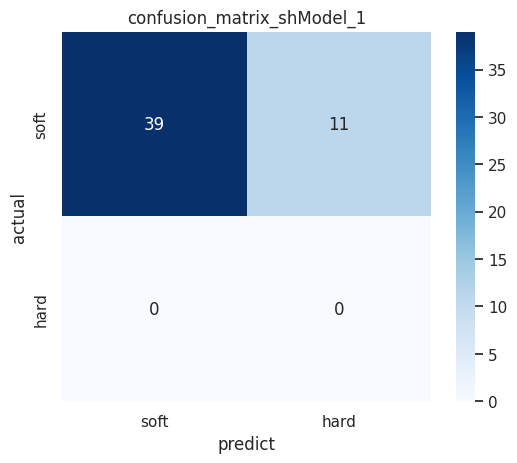

              precision    recall  f1-score   support

        soft      1.000     0.780     0.876        50
        hard      0.000     0.000     0.000         0

    accuracy                          0.780        50
   macro avg      0.500     0.390     0.438        50
weighted avg      1.000     0.780     0.876        50



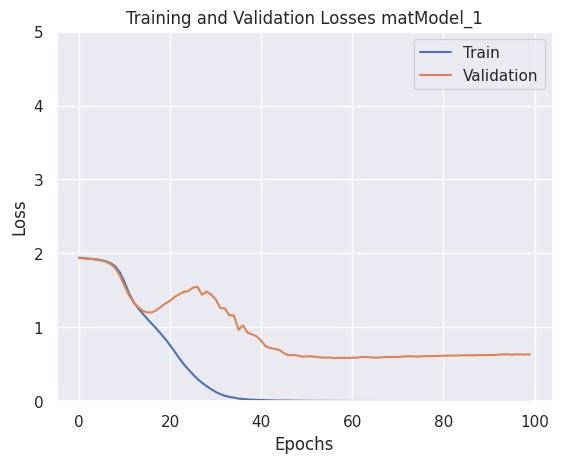

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/me

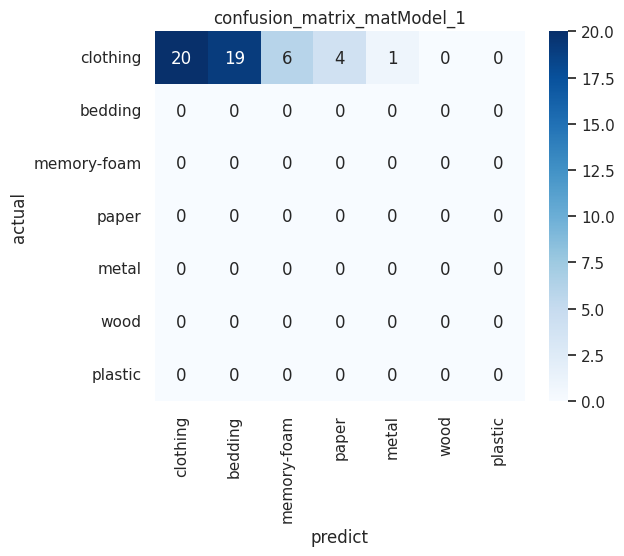

              precision    recall  f1-score   support

    clothing      1.000     0.400     0.571        50
     bedding      0.000     0.000     0.000         0
 memory-foam      0.000     0.000     0.000         0
       paper      0.000     0.000     0.000         0
       metal      0.000     0.000     0.000         0
        wood      0.000     0.000     0.000         0
     plastic      0.000     0.000     0.000         0

   micro avg      0.400     0.400     0.400        50
   macro avg      0.143     0.057     0.082        50
weighted avg      1.000     0.400     0.571        50



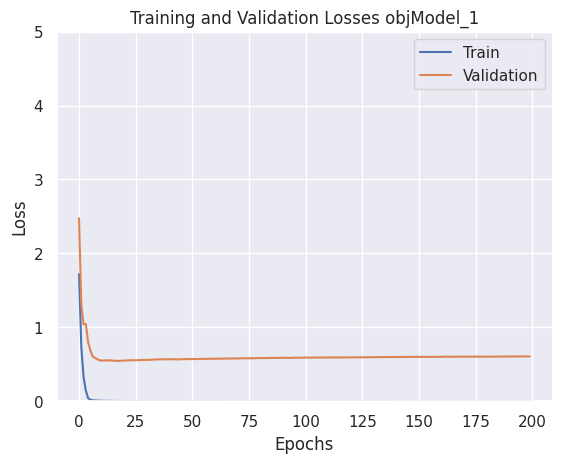

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/me

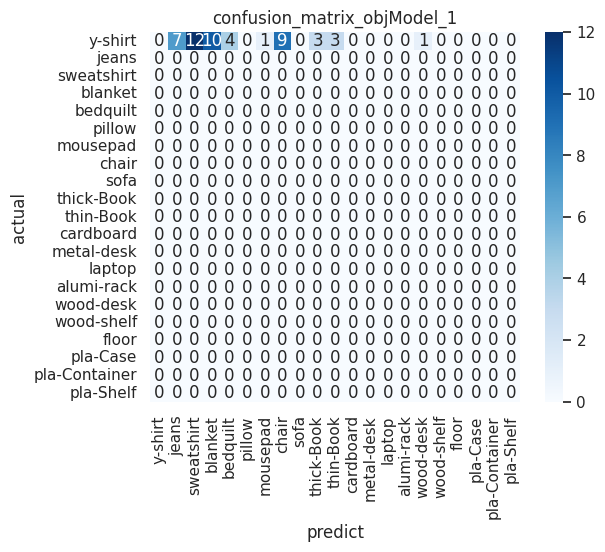

               precision    recall  f1-score   support

      y-shirt      0.000     0.000     0.000      50.0
        jeans      0.000     0.000     0.000       0.0
   sweatshirt      0.000     0.000     0.000       0.0
      blanket      0.000     0.000     0.000       0.0
     bedquilt      0.000     0.000     0.000       0.0
       pillow      0.000     0.000     0.000       0.0
     mousepad      0.000     0.000     0.000       0.0
        chair      0.000     0.000     0.000       0.0
         sofa      0.000     0.000     0.000       0.0
   thick-Book      0.000     0.000     0.000       0.0
    thin-Book      0.000     0.000     0.000       0.0
    cardboard      0.000     0.000     0.000       0.0
   metal-desk      0.000     0.000     0.000       0.0
       laptop      0.000     0.000     0.000       0.0
   alumi-rack      0.000     0.000     0.000       0.0
    wood-desk      0.000     0.000     0.000       0.0
   wood-shelf      0.000     0.000     0.000       0.0
        f

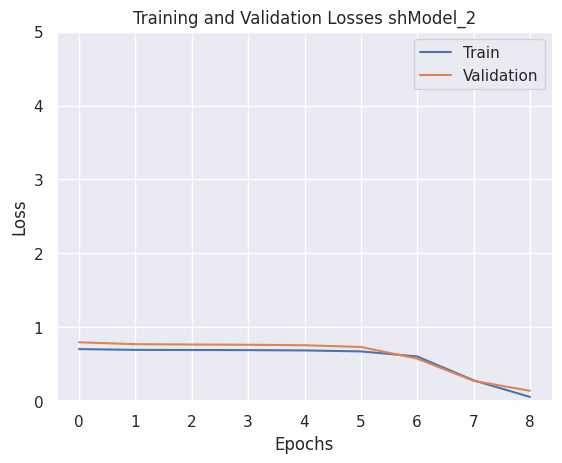

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.p

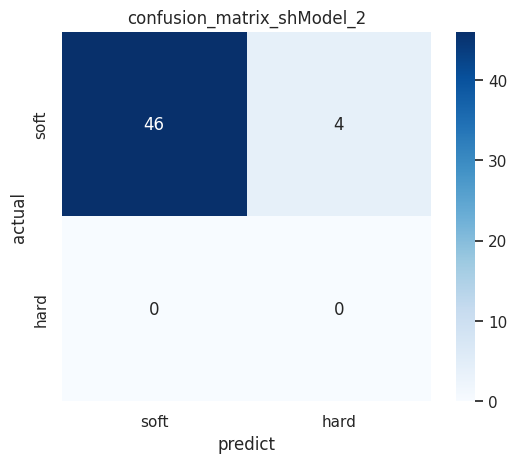

              precision    recall  f1-score   support

        soft      1.000     0.920     0.958        50
        hard      0.000     0.000     0.000         0

    accuracy                          0.920        50
   macro avg      0.500     0.460     0.479        50
weighted avg      1.000     0.920     0.958        50



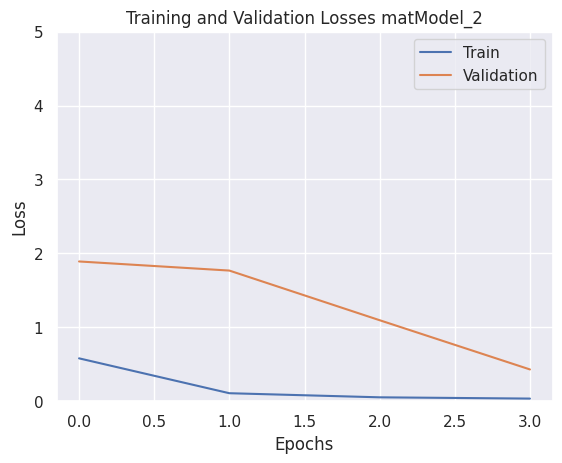

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/me

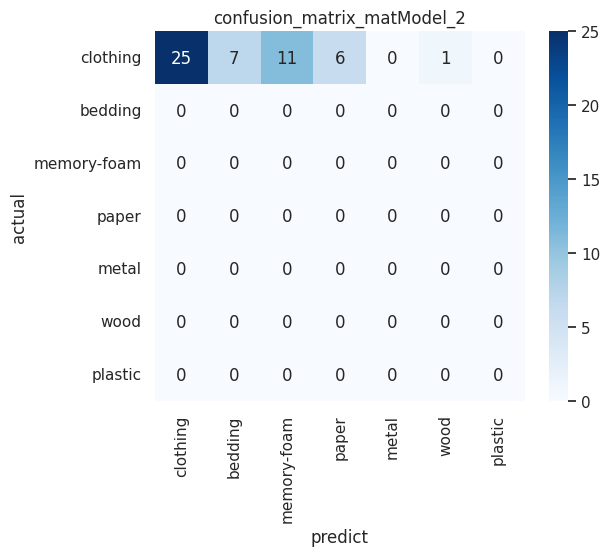

              precision    recall  f1-score   support

    clothing      1.000     0.500     0.667        50
     bedding      0.000     0.000     0.000         0
 memory-foam      0.000     0.000     0.000         0
       paper      0.000     0.000     0.000         0
       metal      0.000     0.000     0.000         0
        wood      0.000     0.000     0.000         0
     plastic      0.000     0.000     0.000         0

   micro avg      0.500     0.500     0.500        50
   macro avg      0.143     0.071     0.095        50
weighted avg      1.000     0.500     0.667        50



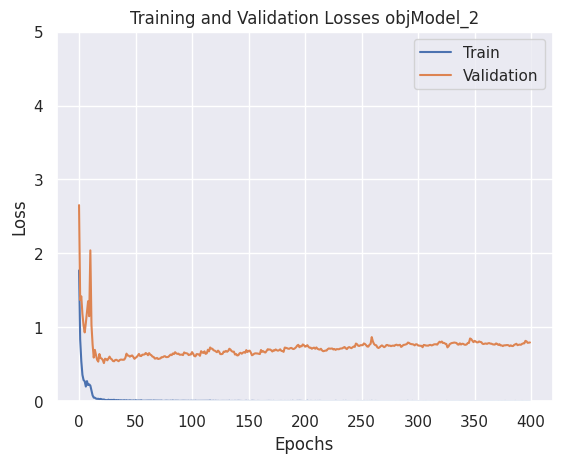

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/me

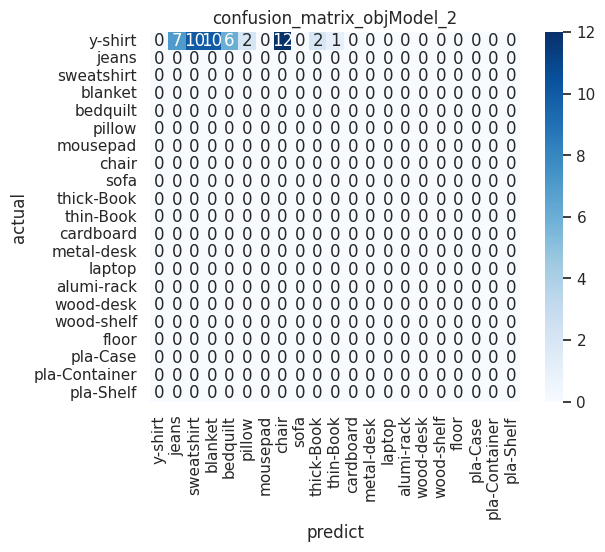

               precision    recall  f1-score   support

      y-shirt      0.000     0.000     0.000      50.0
        jeans      0.000     0.000     0.000       0.0
   sweatshirt      0.000     0.000     0.000       0.0
      blanket      0.000     0.000     0.000       0.0
     bedquilt      0.000     0.000     0.000       0.0
       pillow      0.000     0.000     0.000       0.0
     mousepad      0.000     0.000     0.000       0.0
        chair      0.000     0.000     0.000       0.0
         sofa      0.000     0.000     0.000       0.0
   thick-Book      0.000     0.000     0.000       0.0
    thin-Book      0.000     0.000     0.000       0.0
    cardboard      0.000     0.000     0.000       0.0
   metal-desk      0.000     0.000     0.000       0.0
       laptop      0.000     0.000     0.000       0.0
   alumi-rack      0.000     0.000     0.000       0.0
    wood-desk      0.000     0.000     0.000       0.0
   wood-shelf      0.000     0.000     0.000       0.0
        f

In [19]:
for eval_num in range(1):
    # softhard 1 --------------------------------------------
    #データセットの選択・データローダに読み込む
    # train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
    train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(eval_num)

    # tensorDatasetの作成
    label_num = 2
    train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
    val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    # shuffle はデフォルトで False のため、学習データのみ True に指定
    train_loader = torch.utils.data.DataLoader(train, batch_size)
    val_loader = torch.utils.data.DataLoader(val, batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size)
    # モデルのインポート・構築

    from models.dymn.model import get_model as get_dymn
    shModel = get_dymn(pretrained_name="dymn10_as")

    #パラメータを固定
    for param in shModel.parameters():
        param.requires_gred = False

    #classifierのネットワーク構造を変更・パラメータの更新を許可
    shModel.classifier= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=527, bias=True),
        nn.BatchNorm1d(527),
        nn.Linear(in_features=527, out_features=2, bias=True),  # 新しい層
    )
    # print(shModel)
    # 学習と評価

    # エポックの数
    epoch = 0
    max_epoch = 100
        
    # モデルの初期化
    torch.manual_seed(0)

    # GPU の設定状況に基づいたデバイスの選択
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # モデルのインスタンス化とデバイスへの転送
    net1 = shModel.cuda()

    criterion = F.cross_entropy

    # 最適化手法の選択
    optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
    # エポックごとの訓練データの損失と検証データの損失を保存するリスト
    train_losses = []
    val_losses = []

    train_epoch_loss = 1
    val_epoch_loss = 1
    # 学習ループ
    while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.4) and epoch<max_epoch:
        # 訓練データでの学習
        net1.train()
        for batch in train_loader:
            x, t = batch
            x = x.to(device)        
            t = t.to(device)
            optimizer.zero_grad()
            y = net1(x)
        
            loss = criterion(y[0], t)
            train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
            loss.backward()
            optimizer.step()
        
        # 訓練データでのエポックごとの平均損失を計算し保存
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)
        
        # 検証データでの評価
        net1.eval()
        with torch.no_grad():
            for batch in val_loader:
                x, t = batch

                x = x.to(device)
                t = t.to(device)
                y = net1(x)
                loss = criterion(y[0], t)
                val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
        
        # 検証データでのエポックごとの平均損失を計算し保存
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)
        
        # エポックごとに損失を表示
        # print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
        epoch+=1

    model_name = 'shModel_1'    
    shModel_trained = net1
    SaveModel(shModel_trained,model_name,eval_num)

    
    title = 'Training and Validation Losses '+model_name
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

    plt.show()

    

    # テストデータで確認
    preds , actuals, report = EvalCNN(test_loader,device,0,1)

    print(report)


    # material 1 --------------------------------------------

    #データセットの選択・データローダに読み込む

    train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(eval_num)
    # train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

    # tensorDatasetの作成
    label_num = 1
    train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
    val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

    # データローダに読み込む

    # バッチサイズ
    batch_size = 50

    # shuffle はデフォルトで False のため、学習データのみ True に指定
    train_loader = torch.utils.data.DataLoader(train, batch_size)
    val_loader = torch.utils.data.DataLoader(val, batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size)


    # モデルのインポート・構築

    matModel = shModel_trained

    #パラメータの更新を許可
    for param in matModel.parameters():
        param.requires_gred = False


    # print(model.classifier)

    # 出力層の最後だけ変更
    # model.classifier[5] = torch.nn.Linear(1280,2)
    matModel.classifier= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=527, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=527, out_features=7, bias=True),  # 新しい層
    )
    # print(matModel)
    #学習と評価

    # エポックの数
    epoch = 0
    max_epoch = 100
    # モデルの初期化
    torch.manual_seed(0)

    # GPU の設定状況に基づいたデバイスの選択
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # モデルのインスタンス化とデバイスへの転送
    net2 = matModel.cuda()

    criterion = F.cross_entropy
    
    # 最適化手法の選択
    optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
    # エポックごとの訓練データの損失と検証データの損失を保存するリスト
    train_losses = []
    val_losses = []

    train_epoch_loss = 1.0
    val_epoch_loss = 1.0
    # 学習ループ
    while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        # 訓練データでの学習
        net2.train()
        for batch in train_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            optimizer.zero_grad()
            y = net2(x)
            loss = criterion(y[0], t)
            train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
            loss.backward()
            optimizer.step()
        
        # 訓練データでのエポックごとの平均損失を計算し保存
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)
        
        # 検証データでの評価
        net2.eval()
        with torch.no_grad():
            for batch in val_loader:
                x, t = batch
    
                x = x.to(device)
                t = t.to(device)
                y = net2(x)
                loss = criterion(y[0], t)
                val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
        
        # 検証データでのエポックごとの平均損失を計算し保存
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)
        
        # エポックごとに損失を表示
        # print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
        epoch+=1



    model_name = 'matModel_1'    
    matModel_trained = net2
    SaveModel(matModel_trained,model_name,eval_num)

    title = 'Training and Validation Losses '+model_name
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

    plt.show()


    # テストデータで確認
    preds , actuals, report = EvalCNN(test_loader,device,1,1)

    print(report)


    # object 1 --------------------------------------------

    #データセットの選択・データローダに読み込む

    train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(eval_num)
    # train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

    # tensorDatasetの作成
    label_num = 0
    train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
    val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

    # データローダに読み込む

    # バッチサイズ
    batch_size = 25

    # shuffle はデフォルトで False のため、学習データのみ True に指定
    train_loader = torch.utils.data.DataLoader(train, batch_size)
    val_loader = torch.utils.data.DataLoader(val, batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size)


    # モデルのインポート・構築

    objModel = matModel_trained

    #パラメータの更新を許可
    for param in objModel.parameters():
        param.requires_gred = False


    # print(model.classifier)

    # 出力層の最後だけ変更
    # model.classifier[5] = torch.nn.Linear(1280,2)
    objModel.classifier= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=527, bias=True),
        nn.BatchNorm1d(527),
        nn.ReLU(),
        nn.Linear(in_features=527, out_features=21, bias=True),  # 新しい層
    )
    # print(objModel)
    # エポックの数
    max_epoch = 200
        
    # モデルの初期化
    torch.manual_seed(0)

    # GPU の設定状況に基づいたデバイスの選択
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # モデルのインスタンス化とデバイスへの転送
    net3 = objModel.cuda()

    criterion = F.cross_entropy
    
    # 最適化手法の選択
    optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
    # エポックごとの訓練データの損失と検証データの損失を保存するリスト
    train_losses = []
    val_losses = []

    # 学習ループ
    for epoch in range(max_epoch):
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        # 訓練データでの学習
        net3.train()
        for batch in train_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            optimizer.zero_grad()
            y = net3(x)
            loss = criterion(y[0], t)
            train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
            loss.backward()
            optimizer.step()
        
        # 訓練データでのエポックごとの平均損失を計算し保存
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)
        
        # 検証データでの評価
        net3.eval()
        with torch.no_grad():
            for batch in val_loader:
                x, t = batch
    
                x = x.to(device)
                t = t.to(device)
                y = net3(x)
                loss = criterion(y[0], t)
                val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
        
        # 検証データでのエポックごとの平均損失を計算し保存
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)
        
        # エポックごとに損失を表示
        # print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



    model_name = 'objModel_1'    
    objModel_trained = net3
    SaveModel(objModel_trained,model_name,eval_num)

    title = 'Training and Validation Losses '+model_name
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

    plt.show()


    # テストデータで確認
    preds , actuals, report = EvalCNN(test_loader,device,2,1)

    print(report)

    # softhard 2 --------------------------------------------

    #データセットの選択・データローダに読み込む
    # train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
    train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(eval_num)

    # tensorDatasetの作成
    label_num = 2
    train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
    val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    # shuffle はデフォルトで False のため、学習データのみ True に指定
    train_loader = torch.utils.data.DataLoader(train, batch_size)
    val_loader = torch.utils.data.DataLoader(val, batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size)
    shModel_2 = objModel_trained

    #パラメータの更新を許可
    for param in shModel_2.parameters():
        param.requires_gred = False


    # print(model.classifier)

    # 出力層の最後だけ変更
    # model.classifier[5] = torch.nn.Linear(1280,2)
    shModel_2.classifier= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=960, out_features=1280, bias=False),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(in_features=1280, out_features=527, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
        nn.ReLU(),
        nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
        nn.ReLU(),
        nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
        nn.ReLU(),
        nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層  
    )
    # print(shModel_2)
    # 学習と評価

    # エポックの数
    epoch = 0
    max_epoch = 200
        
    # モデルの初期化
    torch.manual_seed(0)

    # GPU の設定状況に基づいたデバイスの選択
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # モデルのインスタンス化とデバイスへの転送
    net4 = shModel_2.cuda()

    criterion = F.cross_entropy
    
    # 最適化手法の選択
    optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
    # エポックごとの訓練データの損失と検証データの損失を保存するリスト
    train_losses = []
    val_losses = []

    train_epoch_loss = 1
    val_epoch_loss = 1
    # 学習ループ
    while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.4) and epoch<max_epoch:
        # 訓練データでの学習
        net4.train()
        for batch in train_loader:
            x, t = batch
            x = x.to(device)        
            t = t.to(device)
            optimizer.zero_grad()
            y = net4(x)
        
            loss = criterion(y[0], t)
            train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
            loss.backward()
            optimizer.step()
        
        # 訓練データでのエポックごとの平均損失を計算し保存
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)
        
        # 検証データでの評価
        net4.eval()
        with torch.no_grad():
            for batch in val_loader:
                x, t = batch
    
                x = x.to(device)
                t = t.to(device)
                y = net4(x)
                loss = criterion(y[0], t)
                val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
        
        # 検証データでのエポックごとの平均損失を計算し保存
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)
        
        # エポックごとに損失を表示
        # print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
        epoch+=1

    model_name = 'shModel_2'    
    shModel_trained = net4
    SaveModel(shModel_trained,model_name,eval_num)

    title = 'Training and Validation Losses '+model_name
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

    plt.show()


    # テストデータで確認
    preds , actuals, report = EvalCNN(test_loader,device,0,2)

    print(report)

    # material 2 --------------------------------------------

    #データセットの選択・データローダに読み込む

    train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(eval_num)
    # train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

    # tensorDatasetの作成
    label_num = 1
    train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
    val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

    # データローダに読み込む

    # バッチサイズ
    batch_size = 50

    # shuffle はデフォルトで False のため、学習データのみ True に指定
    train_loader = torch.utils.data.DataLoader(train, batch_size)
    val_loader = torch.utils.data.DataLoader(val, batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size)

  

    matModel_2 = shModel_trained

    #パラメータの更新を許可
    for param in matModel_2.parameters():
        param.requires_gred = False


    # print(model.classifier)

    # 出力層の最後だけ変更
    # model.classifier[5] = torch.nn.Linear(1280,2)
    matModel_2.classifier= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=960, out_features=1280, bias=False),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(in_features=1280, out_features=527, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
        nn.BatchNorm1d(176),
        nn.ReLU(),
        nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
        nn.BatchNorm1d(88),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=88, out_features=7, bias=True),  # 新しい層  
    )
    # print(matModel_2)
    #学習と評価
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from tqdm import tqdm

    # エポックの数
    epoch = 0
    max_epoch = 300
    # モデルの初期化
    torch.manual_seed(0)

    # GPU の設定状況に基づいたデバイスの選択
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # モデルのインスタンス化とデバイスへの転送
    net5 = matModel_2.cuda()

    criterion = F.cross_entropy
    
    # 最適化手法の選択
    optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
    # エポックごとの訓練データの損失と検証データの損失を保存するリスト
    train_losses = []
    val_losses = []

    train_epoch_loss = 1.0
    val_epoch_loss = 1.0
    # 学習ループ
    while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        # 訓練データでの学習
        net5.train()
        for batch in train_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            optimizer.zero_grad()
            y = net5(x)
            loss = criterion(y[0], t)
            train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
            loss.backward()
            optimizer.step()
        
        # 訓練データでのエポックごとの平均損失を計算し保存
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)
        
        # 検証データでの評価
        net5.eval()
        with torch.no_grad():
            for batch in val_loader:
                x, t = batch
    
                x = x.to(device)
                t = t.to(device)
                y = net5(x)
                loss = criterion(y[0], t)
                val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
        
        # 検証データでのエポックごとの平均損失を計算し保存
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)
        
        # エポックごとに損失を表示
        # print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
        epoch+=1



    model_name = 'matModel_2'    
    matModel_trained = net5
    SaveModel(matModel_trained,model_name,eval_num)

    title = 'Training and Validation Losses '+model_name
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

    plt.show()


    # テストデータで確認
    preds , actuals, report = EvalCNN(test_loader,device,1,2)

    print(report)


    # object 2 --------------------------------------------

    #データセットの選択・データローダに読み込む

    train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(eval_num)
    # train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

    # tensorDatasetの作成
    label_num = 0
    train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
    val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

    # データローダに読み込む

    # バッチサイズ
    batch_size = 25

    # shuffle はデフォルトで False のため、学習データのみ True に指定
    train_loader = torch.utils.data.DataLoader(train, batch_size)
    val_loader = torch.utils.data.DataLoader(val, batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size)

    objModel_2 = matModel_trained

    # パラメータの更新を許可
    for param in objModel_2.parameters():
        param.requires_grad =  True # requires_gred -> requires_grad

    # 新しい層の追加とBatch Normalizationの導入
    objModel_2.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(in_features=1280, out_features=527, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
        nn.BatchNorm1d(176),
        nn.ReLU(),
        nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
        nn.BatchNorm1d(88),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    )

    # print(objModel_2)

    # エポックの数
    max_epoch = 400
        
    # モデルの初期化
    torch.manual_seed(0)

    # GPU の設定状況に基づいたデバイスの選択
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # モデルのインスタンス化とデバイスへの転送
    net6 = objModel_2.cuda()

    criterion = F.cross_entropy
    
    # 最適化手法の選択
    optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
    # エポックごとの訓練データの損失と検証データの損失を保存するリスト
    train_losses = []
    val_losses = []

    # 学習ループ
    for epoch in range(max_epoch):
        train_epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        # 訓練データでの学習
        net6.train()
        for batch in train_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            optimizer.zero_grad()
            y = net6(x)
            loss = criterion(y[0], t)
            train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
            loss.backward()
            optimizer.step()
        
        # 訓練データでのエポックごとの平均損失を計算し保存
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)
        
        # 検証データでの評価
        net6.eval()
        with torch.no_grad():
            for batch in val_loader:
                x, t = batch
    
                x = x.to(device)
                t = t.to(device)
                y = net6(x)
                loss = criterion(y[0], t)
                val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
        
        # 検証データでのエポックごとの平均損失を計算し保存
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)
        
        # エポックごとに損失を表示
        # print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



    model_name = 'objModel_2'    
    objModel_trained = net6
    SaveModel(objModel_trained,model_name,eval_num)

    title = 'Training and Validation Losses '+model_name
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

    plt.show()

    # テストデータで確認
    preds , actuals, report = EvalCNN(test_loader,device,2,2)

    print(report)
